In [1]:
import numpy as np

def tsv_line_to_array(line):
    lst = [float(elem) for elem in line.rstrip().split('\t')]
    return np.array(lst)

def readtsv(filename):
    print('starting readtsv')
    with open(filename) as fin:
        for i, line in enumerate(fin):
            print(f'reading line {i}')
            yield tsv_line_to_array(line)
    print('finished readtsv')

def add1(arrays_iter):
    print('starting adding 1')
    for i, arr in enumerate(arrays_iter):
        print(f'adding 1 to line {i}')
        yield arr + 1
    print('finished adding 1')

def log(arrays_iter):
    print('starting log')
    for i, arr in enumerate(arrays_iter):
        print(f'taking log of array {i}')
        yield np.log(arr)
    print('finished log')

def running_mean(arrays_iter):
    print('starting running mean')
    for i, arr in enumerate(arrays_iter):
        if i == 0:
            mean = arr
        mean += (arr - mean) / (i + 1)
        print(f'adding line {i} to the running mean')
    print('returning mean')
    return mean

In [2]:
import toolz as tz
from toolz import curried as c
from glob import glob
import itertools as it

LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

def is_sequence(line):
    return not line.startswith('>')

def is_nucleotide(letter):
    return letter in LDICT  # ignore 'N'

@tz.curry
def increment_model(model, index):
    model[index] += 1


def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(open),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))


def markov(seq):
    """Get a 1st-order Markov model from a sequence of nucleotides."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(seq,
                    c.sliding_window(2),        # each successive tuple
                    c.map(PDICT.__getitem__),   # location in matrix of tuple
                    c.map(increment_model(model))))  # increment matrix
    # convert counts to transition probability matrix
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

In [3]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

In [4]:
%%timeit -r 1 -n 1
dm = '../data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)

7.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
import toolz as tz
filename = '../data/expr.tsv'
mean = tz.pipe(filename, readtsv, add1, log, running_mean)

# This is equivalent to nesting the functions like this:
# running_mean(log(add1(readtsv(filename))))

starting running mean
starting log
starting adding 1
starting readtsv
reading line 0
adding 1 to line 0
taking log of array 0
adding line 0 to the running mean
reading line 1
adding 1 to line 1
taking log of array 1
adding line 1 to the running mean
reading line 2
adding 1 to line 2
taking log of array 2
adding line 2 to the running mean
reading line 3
adding 1 to line 3
taking log of array 3
adding line 3 to the running mean
reading line 4
adding 1 to line 4
taking log of array 4
adding line 4 to the running mean
finished readtsv
finished adding 1
finished log
returning mean


In [9]:
# Download dm6.fa.gz from ftp://hgdownload.cse.ucsc.edu/goldenPath/dm6/bigZips/
# Unzip before using: gzip -d dm6.fa.gz
dm = '../data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)
# we use `take` to just run on the first 10 million bases, to speed things up.
# the take step can just be removed if you have ~5-10 mins to wait.

In [10]:
print('    ', '      '.join('ACGTacgt'), '\n')
print(model)

     A      C      G      T      a      c      g      t 

[[3.48163917e-01 1.82284789e-01 1.94114427e-01 2.74828864e-01
  2.34047644e-04 8.33492404e-05 1.00837697e-04 1.89768360e-04]
 [3.22172215e-01 2.24256580e-01 1.98474420e-01 2.54230493e-01
  3.08933339e-04 1.78079409e-04 1.39708707e-04 2.39570917e-04]
 [2.62420869e-01 2.71834731e-01 2.25770047e-01 2.39242561e-01
  1.95928220e-04 1.87601270e-04 1.38129395e-04 2.10133016e-04]
 [2.09423028e-01 1.98513236e-01 2.44588315e-01 3.46970729e-01
  1.30194693e-04 9.35306706e-05 8.45517262e-05 1.96414408e-04]
 [3.14920419e-03 2.79172696e-03 2.97330269e-03 2.92223452e-03
  3.48602718e-01 1.77507306e-01 1.65795671e-01 2.96257838e-01]
 [2.12485618e-03 2.39394277e-03 2.92283710e-03 2.64447166e-03
  3.75849015e-01 1.95301191e-01 1.51532866e-01 2.67230821e-01]
 [2.29151858e-03 3.18006659e-03 3.14265405e-03 2.42246249e-03
  2.81333009e-01 2.31387257e-01 1.94451719e-01 2.81791313e-01]
 [1.95061502e-03 2.15141362e-03 3.21851478e-03 3.49389572e-03
  2.4

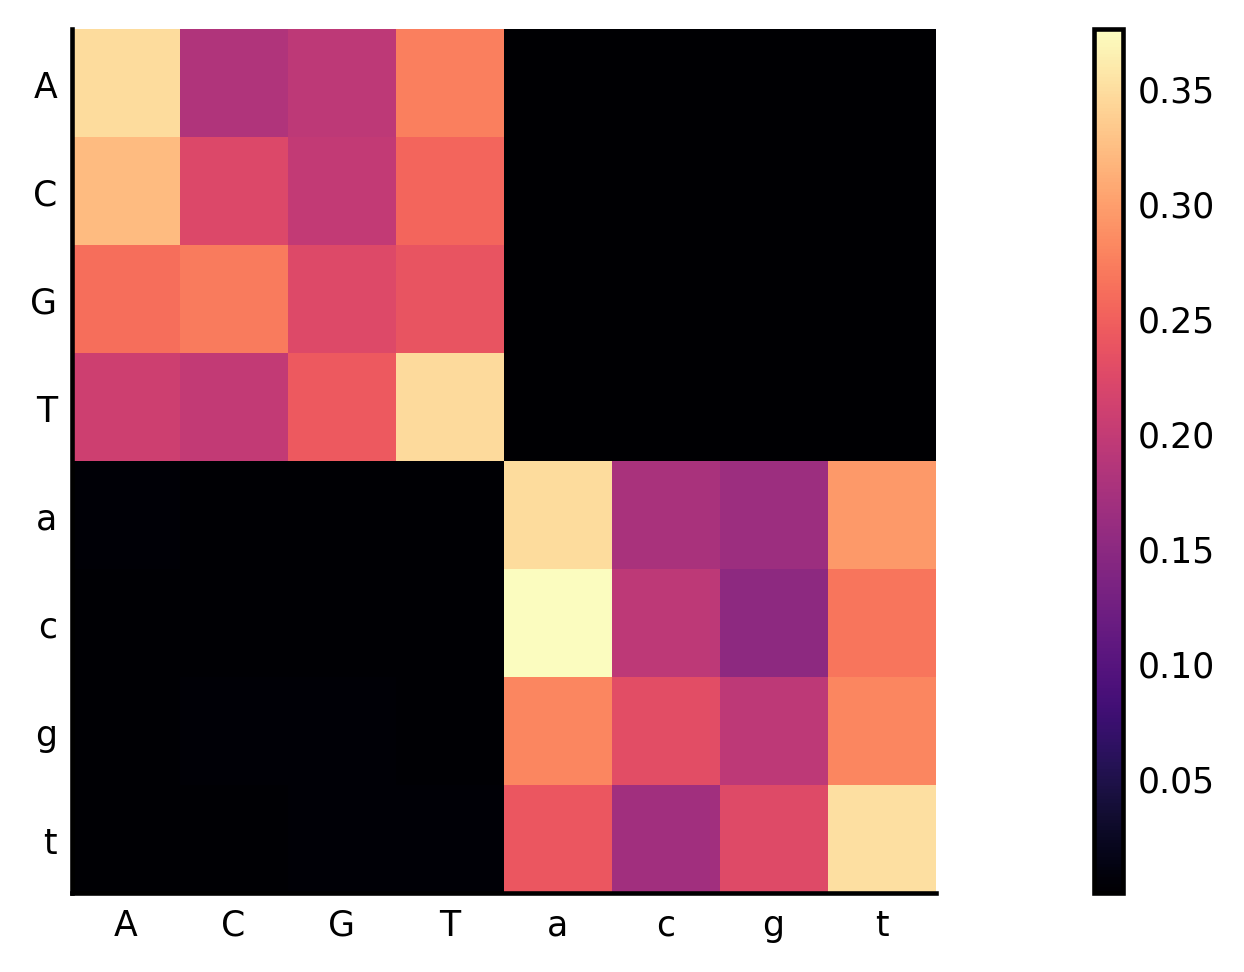

In [11]:
def plot_model(model, labels, figure=None):
    fig = figure or plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    im = ax.imshow(model, cmap='magma');
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.8])
    plt.colorbar(im, cax=axcolor)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks(range(8))
        axis.set_ticks_position('none')
        axis.set_ticklabels(labels)
    return ax

plot_model(model, labels='ACGTacgt');

In [12]:
import gzip

gzopen = tz.curry(gzip.open)

In [13]:
def genome_gz(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(gzopen(mode='rt')),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))

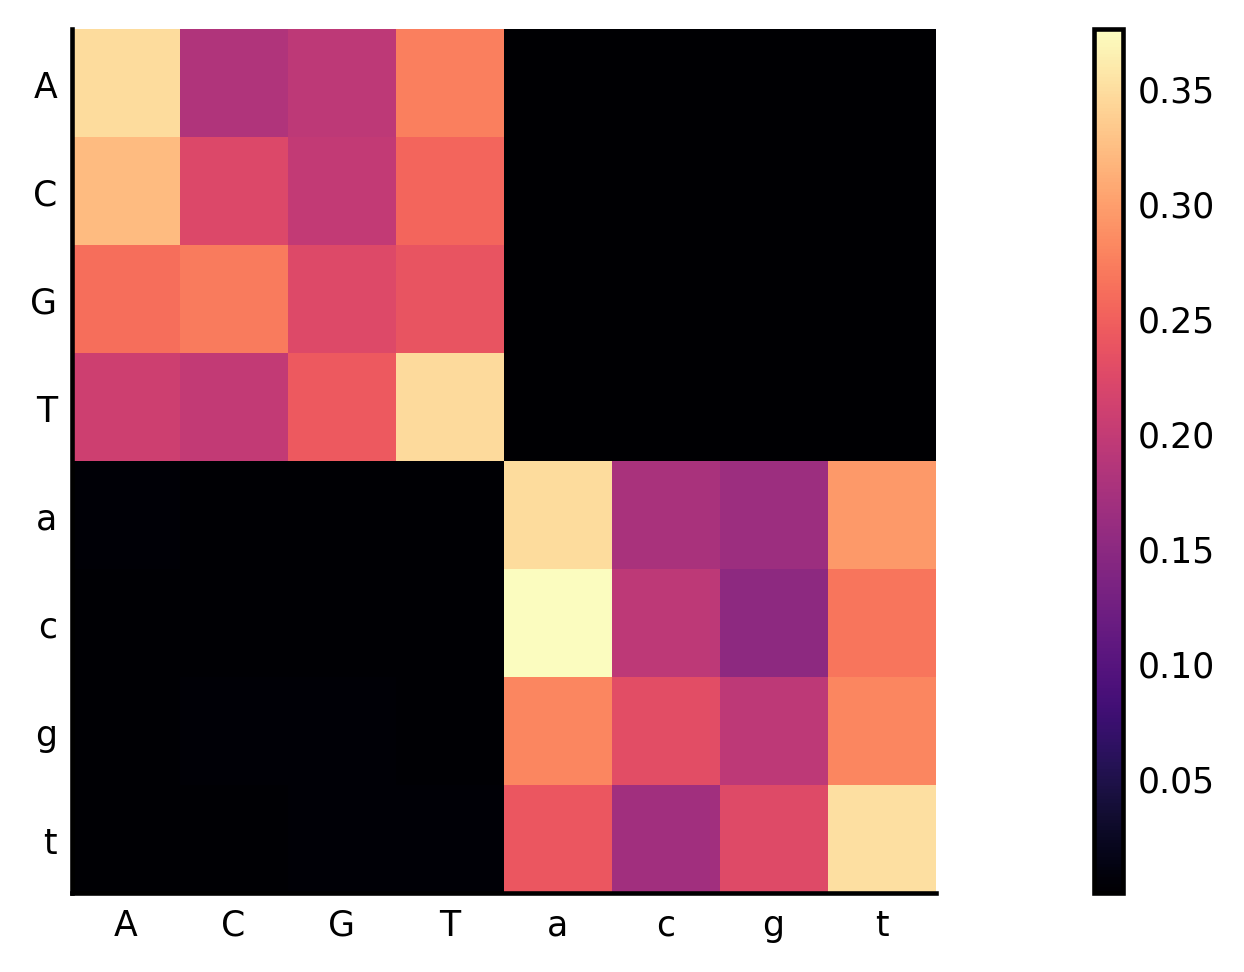

In [14]:
dm = '../data/dm6.fa.gz'
model = tz.pipe(dm, genome_gz, c.take(10**7), markov)
plot_model(model, labels='ACGTacgt')
